# Agglomerative Hierarchical Clustering

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import AgglomerativeClustering

In [3]:
# ---------- 1. Load and Inspect ----------

df = pd.read_csv("Mall_Customers.csv")
print(df.head(), "\n")

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40 



In [4]:
print(df.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None 



In [5]:
print(df.describe(), "\n")

       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000 



In [6]:
# ---------- 2. Preprocess ----------

# Encode 'Genre' to numeric
le = LabelEncoder()
df['Genre_Code'] = le.fit_transform(df['Genre'])  # Male=1, Female=0
print("Genre mapping:", dict(zip(le.classes_, le.transform(le.classes_))), "\n")

# We'll cluster on Age, Annual Income, Spending Score
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

# Standardize features for better linkage distances
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Genre mapping: {'Female': 0, 'Male': 1} 



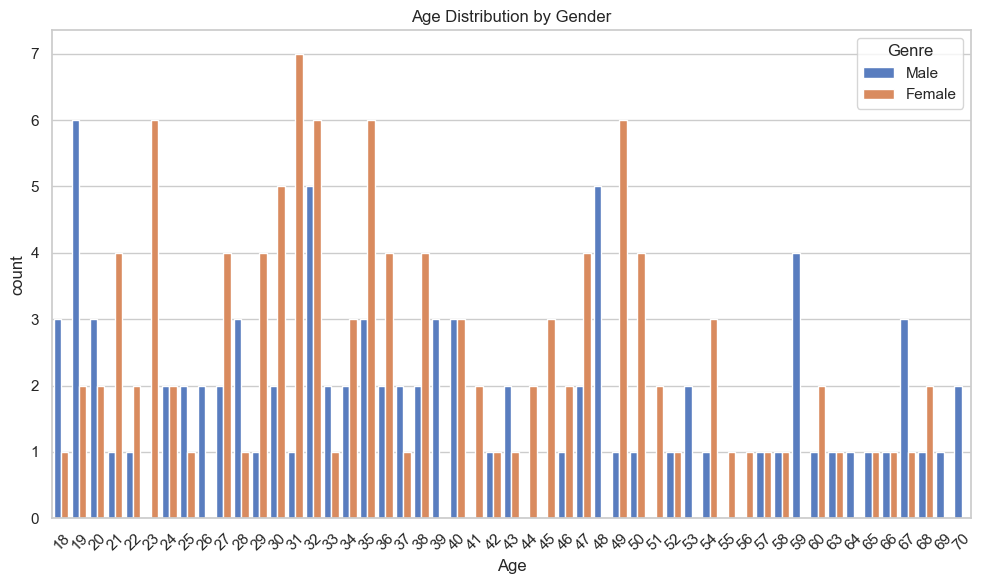

In [7]:
# ---------- 3. Exploratory Data Analysis ----------

sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(10,6))
sns.countplot(x='Age', hue='Genre', data=df)
plt.title("Age Distribution by Gender")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

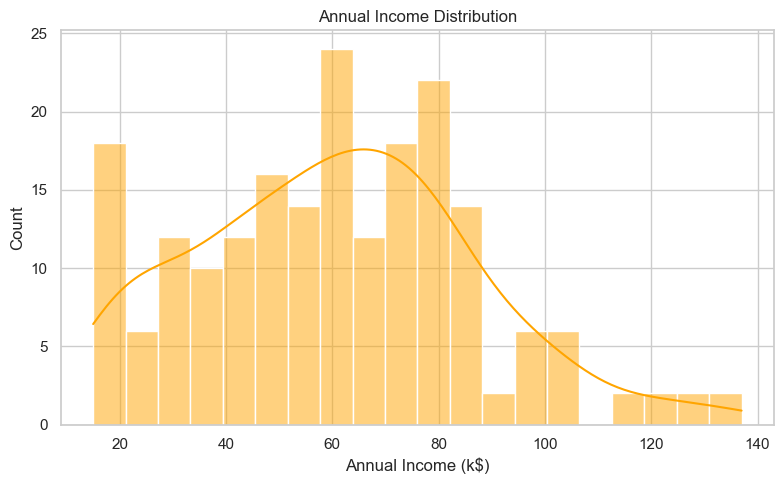

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(df['Annual Income (k$)'], bins=20, kde=True, color='orange')
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income (k$)")
plt.tight_layout()
plt.show()

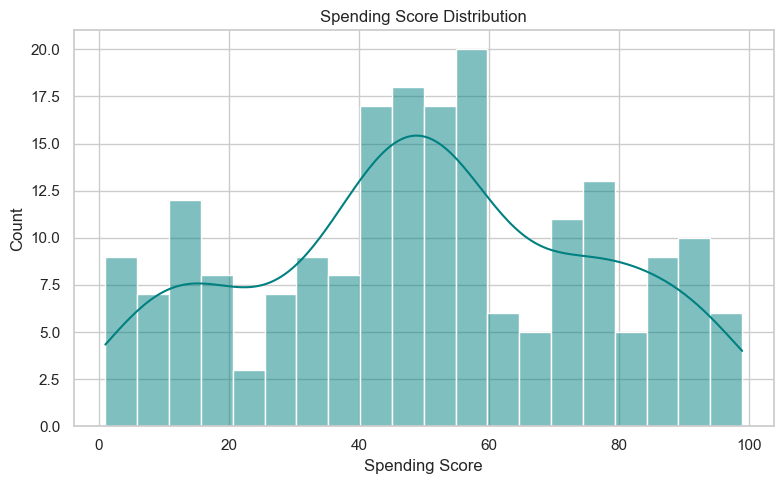

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(df['Spending Score (1-100)'], bins=20, kde=True, color='teal')
plt.title("Spending Score Distribution")
plt.xlabel("Spending Score")
plt.tight_layout()
plt.show()

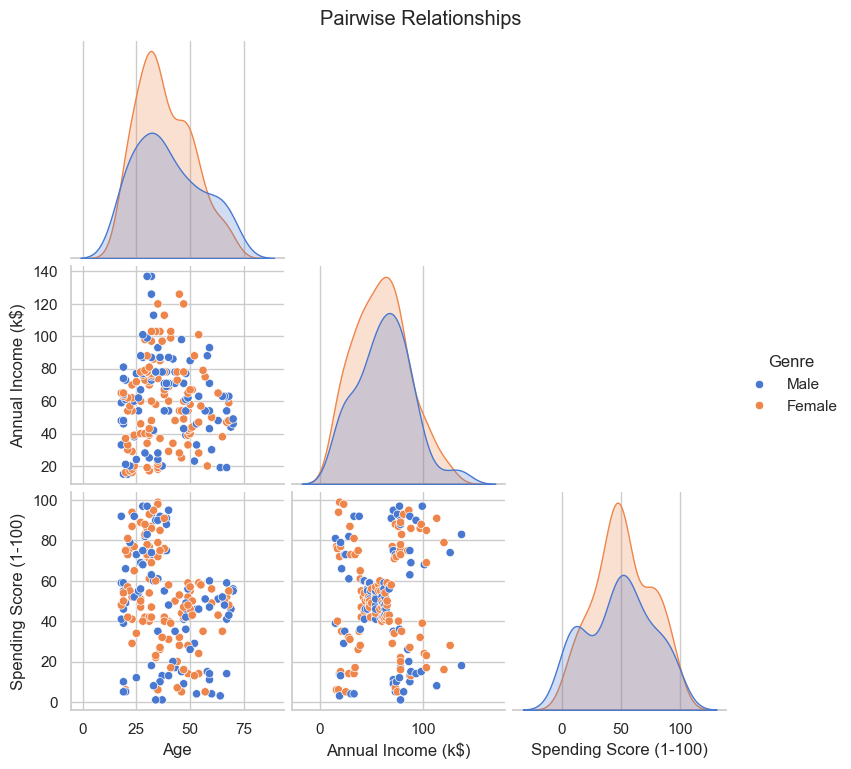

In [10]:
# Pairplot to see pairwise relationships
sns.pairplot(df[['Age','Annual Income (k$)','Spending Score (1-100)','Genre']], 
             hue='Genre', corner=True, diag_kind='kde', height=2.5)
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

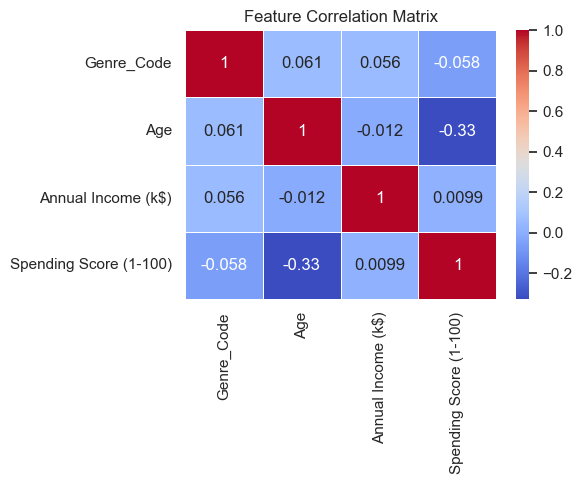

In [11]:
# Correlation heatmap (only numeric columns)
plt.figure(figsize=(6,5))
sns.heatmap(df[['Genre_Code','Age','Annual Income (k$)','Spending Score (1-100)']].corr(),
            annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

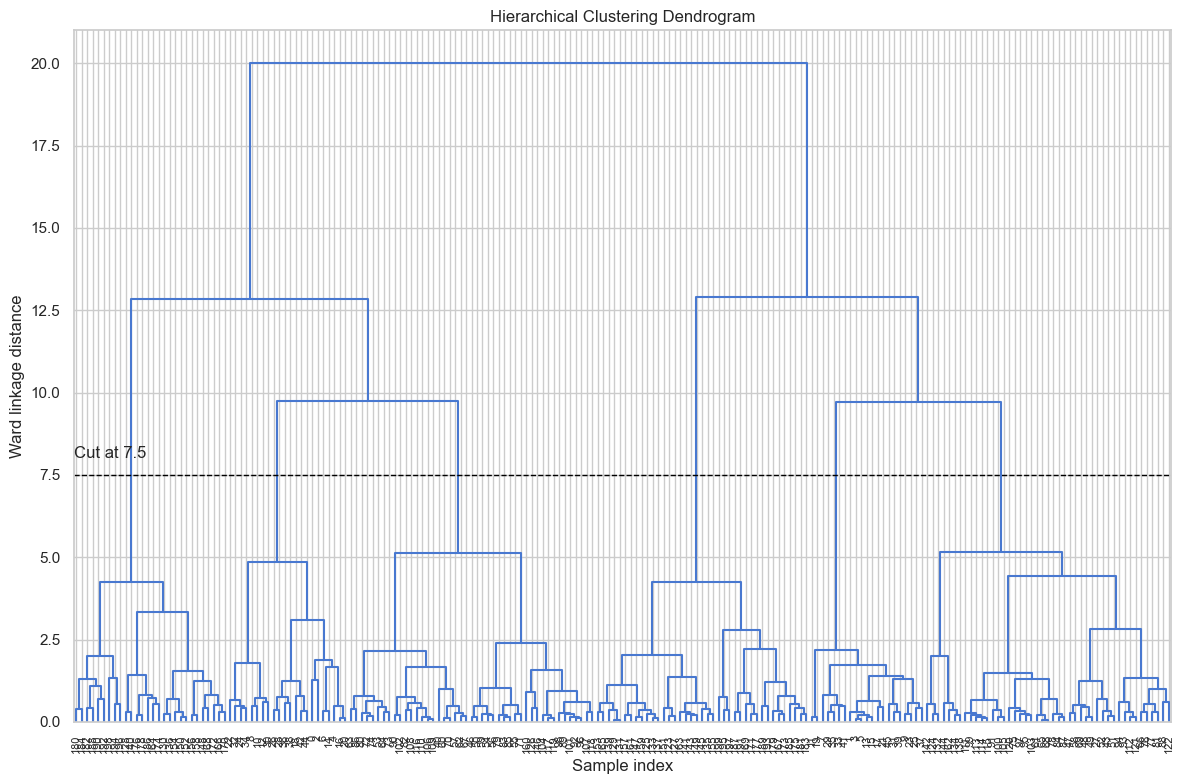

In [12]:
# ---------- 4. Dendrogram (to choose # clusters) ----------

plt.figure(figsize=(12,8))
dendro = sch.dendrogram(
    sch.linkage(X_scaled, method='ward'),
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=0
)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Ward linkage distance")
# draw a horizontal line to suggest a cut
plt.axhline(y=7.5, color='black', linestyle='--', lw=1)
plt.text(0, 8, 'Cut at 7.5', fontsize=12)
plt.tight_layout()
plt.show()

In [13]:
# ---------- 5. Fit Agglomerative Clustering ----------

n_clusters = 5
hc = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',   # <-- updated here
    linkage='ward'
)
y_hc = hc.fit_predict(X_scaled)
df['Cluster'] = y_hc

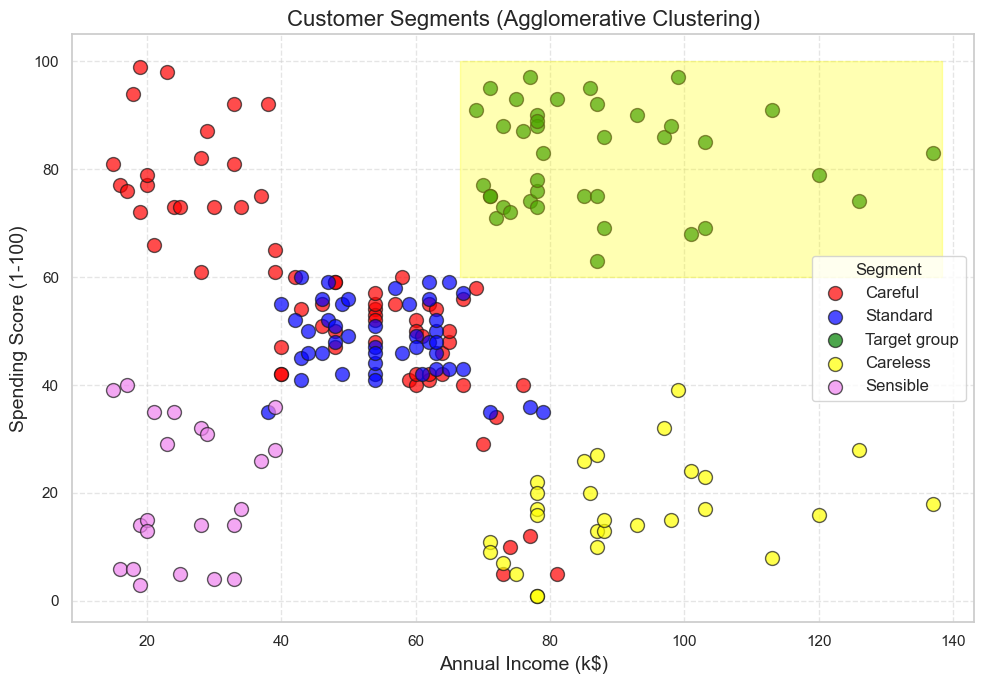

In [17]:
# ---------- 6. Visualize Clusters with Custom Names ----------

# 1. Define your cluster‐name mapping
cluster_names = {
    0: 'Careful',
    1: 'Standard',
    2: 'Target group',
    3: 'Careless',
    4: 'Sensible'
}

# Optional: pick a matching color palette
colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'violet'
}

plt.figure(figsize=(10,7))

for cluster_idx, name in cluster_names.items():
    mask = (y_hc == cluster_idx)
    plt.scatter(
        df.loc[mask, 'Annual Income (k$)'],
        df.loc[mask, 'Spending Score (1-100)'],
        s=100,
        c=colors[cluster_idx],
        label=name,
        alpha=0.7,
        edgecolor='k'
    )

plt.title("Customer Segments (Agglomerative Clustering)", fontsize=16)
plt.xlabel("Annual Income (k$)", fontsize=14)
plt.ylabel("Spending Score (1-100)", fontsize=14)
plt.legend(title="Segment", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# If you still want that yellow highlight band:
plt.axhspan(ymin=60, ymax=100, xmin=0.43, xmax=0.965,
            alpha=0.3, color="yellow")

plt.tight_layout()
plt.show()


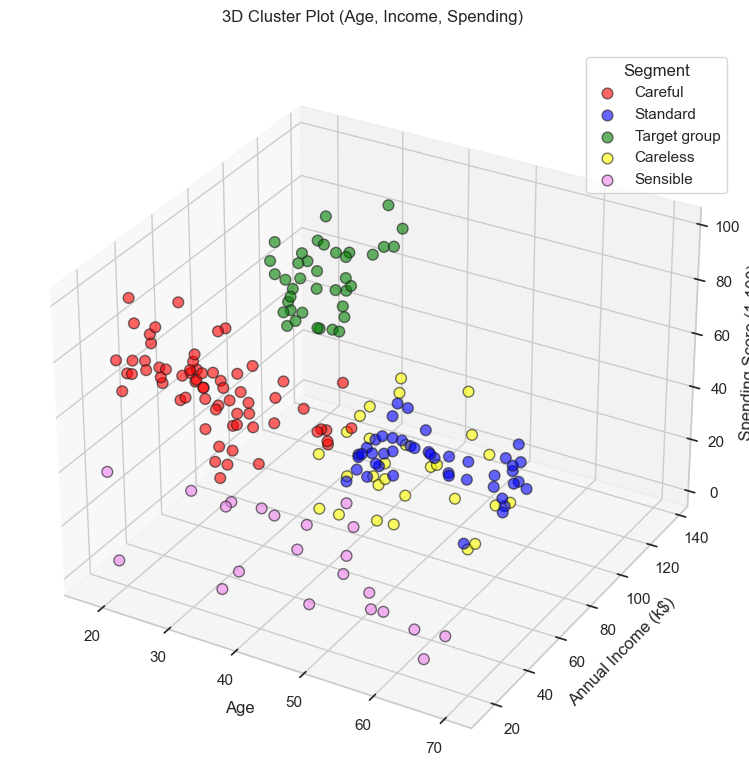

In [18]:
# ---------- 6b. 3D Cluster Plot with Custom Names ----------

from mpl_toolkits.mplot3d import Axes3D  # if not already imported

# reuse the same mapping dicts from before
cluster_names = {
    0: 'Careful',
    1: 'Standard',
    2: 'Target group',
    3: 'Careless',
    4: 'Sensible'
}

colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'violet'
}

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

for cluster_idx, name in cluster_names.items():
    mask = (y_hc == cluster_idx)
    ax.scatter(
        df.loc[mask, 'Age'],
        df.loc[mask, 'Annual Income (k$)'],
        df.loc[mask, 'Spending Score (1-100)'],
        s=60,
        c=colors[cluster_idx],
        label=name,
        alpha=0.6,
        edgecolor='k'
    )

ax.set_title("3D Cluster Plot (Age, Income, Spending)", pad=20)
ax.set_xlabel("Age")
ax.set_ylabel("Annual Income (k$)")
ax.set_zlabel("Spending Score (1-100)")
ax.legend(title="Segment")

plt.tight_layout()
plt.show()


In [22]:
from sklearn.cluster import KMeans

# Assuming 'X_scaled' is your preprocessed data
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_scaled)

# Add cluster labels to the DataFrame
df['KMeans_Cluster'] = y_kmeans

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


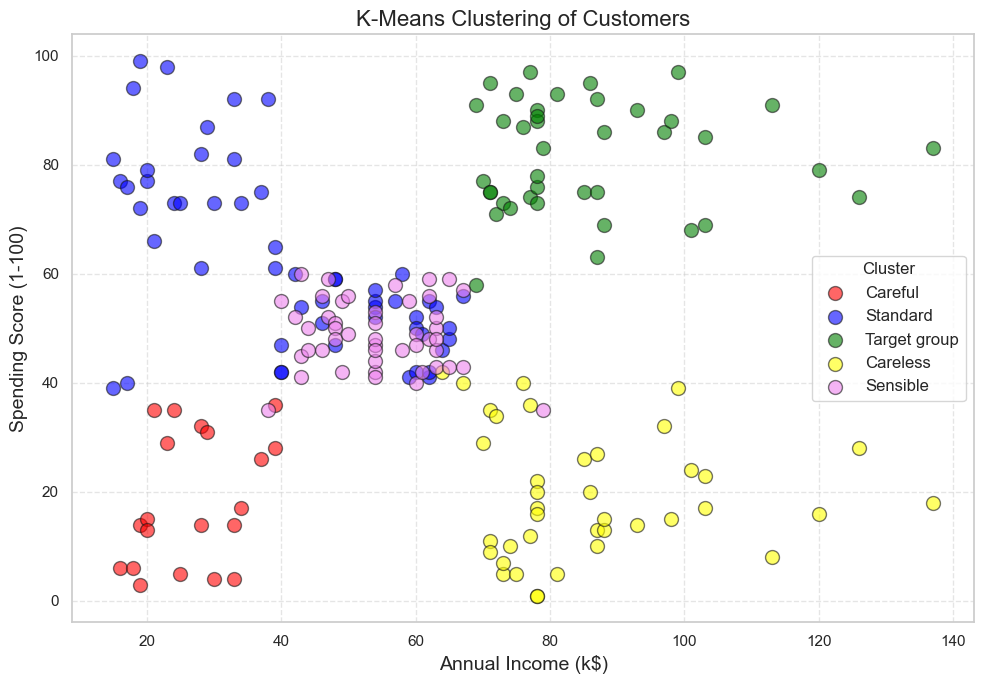

In [23]:
import matplotlib.pyplot as plt

# Define cluster names and colors
cluster_names = {
    0: 'Careful',
    1: 'Standard',
    2: 'Target group',
    3: 'Careless',
    4: 'Sensible'
}
colors = ['red', 'blue', 'green', 'yellow', 'violet']

plt.figure(figsize=(10, 7))
for cluster in range(n_clusters):
    mask = (df['KMeans_Cluster'] == cluster)
    plt.scatter(
        df.loc[mask, 'Annual Income (k$)'],
        df.loc[mask, 'Spending Score (1-100)'],
        s=100,
        c=colors[cluster],
        label=cluster_names[cluster],
        alpha=0.6,
        edgecolor='k'
    )
plt.title("K-Means Clustering of Customers", fontsize=16)
plt.xlabel("Annual Income (k$)", fontsize=14)
plt.ylabel("Spending Score (1-100)", fontsize=14)
plt.legend(title="Cluster", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [25]:
from sklearn.metrics import silhouette_score

# Assuming 'y_agglo' contains labels from Agglomerative Clustering
silhouette_agglo = silhouette_score(X_scaled, y_hc)
silhouette_kmeans = silhouette_score(X_scaled, y_kmeans)

print(f"Agglomerative Clustering Silhouette Score: {silhouette_agglo:.3f}")
print(f"K-Means Clustering Silhouette Score: {silhouette_kmeans:.3f}")

Agglomerative Clustering Silhouette Score: 0.390
K-Means Clustering Silhouette Score: 0.417
